## dog_breeds_identification kaggle game

### Preparing

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


#### gpu not good for cpu mode

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [33]:
torch.cuda.set_device(0)

### Download from kaggle















In [8]:
#!pip install kaggle
# download your own kaggle.json  put it under ~/.kaggle/
# run kaggle competitions download -c dog-breed-identification
# zip file will locates in ~/kaggle/..

In [9]:
PATH = "data/dogbreeds/"

### Prepare data 


In [10]:
!ls {PATH}

labels.csv.zip	       sample_submission.csv.zip  test.zip  train.zip
sample_submission.csv  test			  train


#### check train set

In [12]:
!pwd

/home/ubuntu/fastai/courses/dl1


In [13]:
label_csv = f'{PATH}labels.csv'
print(label_csv)
#list of rows, minus 1, nubmer of rows in CSV, number of imgs
n = len(list(open(label_csv)))-1
print(n)

data/dogbreeds/labels.csv
10222


In [14]:
labels_df= pd.read_csv(label_csv)
labels_df.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
len(labels_df['breed'].unique())

120

In [16]:
labels_df.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


#### 20% as validation data

In [17]:
def get_cv_idxs(n, cv_idx=4, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [18]:
# get crossvalidation indexes custom FASTAI
val_idxs = get_cv_idxs(n)
print(val_idxs)

[3694 1573 6281 ..., 5734 5191 5390]


### Train model using FastAi steps

#### some basic set

不同的架构有不同的参数，结构

In [20]:

arch=resnet34
# arch=resnet101_64
# arch=resnext54
bs=24
sz=224

####  load data enable data agument 

In [21]:
#That's the way of it
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train',
                                    label_csv,tfms=tfms,
                                    val_idxs=val_idxs,
                                    suffix='.jpg',
                                    test_name='test',
                                    bs =bs)

#### dealing with huge or tiny images

In [22]:
# fn = PATH+data.trn_ds.fnames[0]
fn = PATH + data.val_ds.fnames[1]
fn

'data/dogbreeds/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'

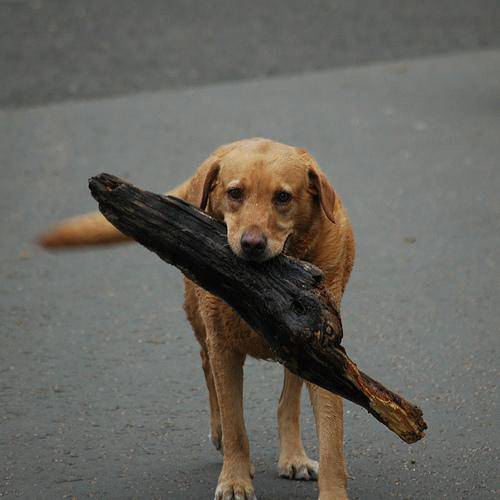

In [23]:
img = PIL.Image.open(fn)
img

In [24]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

* zip用法
```
>>>a = [1,2,3]
>>> b = [4,5,6]
>>> c = [4,5,6,7,8]
>>> zipped = zip(a,b)     # 打包为元组的列表
[(1, 4), (2, 5), (3, 6)]
>>> zip(a,c)              # 元素个数与最短的列表一致
[(1, 4), (2, 5), (3, 6)]
>>> zip(*zipped)          # 与 zip 相反，可理解为解压，返回二维矩阵式
[(1, 2, 3), (4, 5, 6)]
```

In [25]:
# 行列分开，分别统计
row_sz,col_sz = list(zip(*size_d.values()));

row_sz = np.array(row_sz); col_sz=np.array(col_sz)

(array([3014., 5029.,   91.,   12.,    8.,    3.,   17.,    1.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

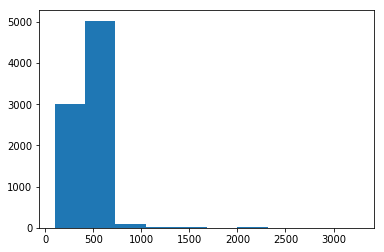

In [73]:
plt.hist(row_sz)

(array([  20.,   97.,  255.,  284.,  204.,  838.,  969.,  365.,  242.,  221.]),
 array([  97. ,  137.2,  177.4,  217.6,  257.8,  298. ,  338.2,  378.4,  418.6,  458.8,  499. ]),
 <a list of 10 Patch objects>)

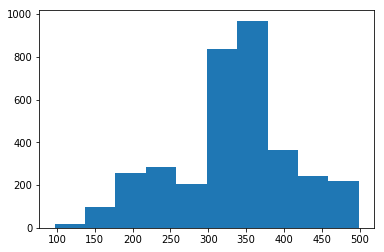

In [26]:
plt.hist(row_sz[row_sz < 500])

(array([ 2713.,  5267.,   131.,    21.,    15.,     8.,    17.,     4.,     0.,     2.]),
 array([  102. ,   336.6,   571.2,   805.8,  1040.4,  1275. ,  1509.6,  1744.2,  1978.8,  2213.4,  2448. ]),
 <a list of 10 Patch objects>)

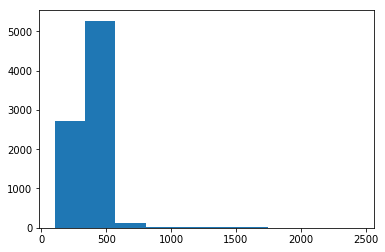

In [27]:
plt.hist(col_sz)

In [58]:
len(data.trn_ds),len(data.val_ds)

(8178, 2044)

In [59]:
data.classes[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [30]:
# 输入sz和batch sz为参数，可以调整不同大小数据的训练结果
def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train',
                                    label_csv,tfms=tfms,
                                    val_idxs=val_idxs,
                                    suffix='.jpg',
                                    test_name='test',
                                    bs =bs)
    return data if (sz > 300) else data.resize(340,'tmp')
    

#### learn a right learning rate using lr_find     

In [31]:
# 先训练224
bs=24
sz=224
data = get_data(sz,bs);

A Jupyter Widget

In [60]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

A Jupyter Widget

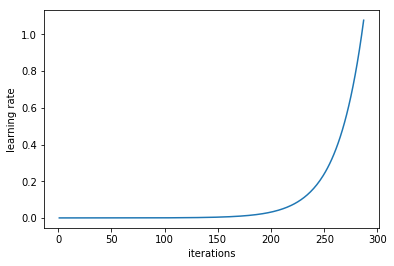

In [61]:
learn.lr_find()
# plot lr and iterations
learn.sched.plot_lr()

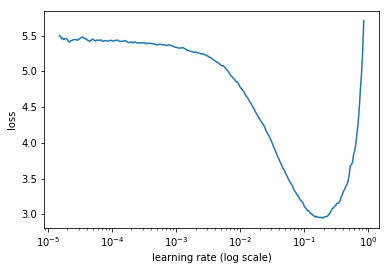

In [62]:
#plot lost function and lr ,thus find the best lr
learn.sched.plot()

In [63]:
suitable_lr = 0.03;

#### pre-train last layer 1-2 epochs 
precomputed=True
Try small size data set first!

In [64]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(suitable_lr, 2)

A Jupyter Widget

 68%|██████▊   | 231/341 [00:02<00:01, 104.33it/s, loss=1.27]

Exception in thread Thread-22:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.132588   0.689319   0.785225  
    1      0.864913   0.593541   0.815068                     



[array([ 0.59354]), 0.81506849315068497]

#### using SGDR (restart) retrain last layer 

In [65]:
learn.precompute=False
learn.fit(suitable_lr, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.695408   0.507696   0.838552  
    1      0.672501   0.491196   0.850294                    
    2      0.59468    0.487972   0.843444                    



[array([ 0.48797]), 0.84344422793901597]

In [66]:
learn.save('dogbreeds_224_1st')

#### check point if  sth wrong can restart here

In [67]:
learn.load('dogbreeds_224_1st')

#### check result 1st time

In [71]:
log_preds = learn.predict()

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
# probs = np.exp(log_preds)
probs



array([ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.00004], dtype=float32)

####  lr_find again

A Jupyter Widget

 80%|███████▉  | 272/341 [00:46<00:11,  5.81it/s, loss=1.84] 

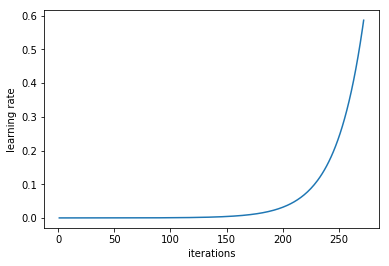

In [72]:

learn.lr_find()
# plot lr and iterations
learn.sched.plot_lr()

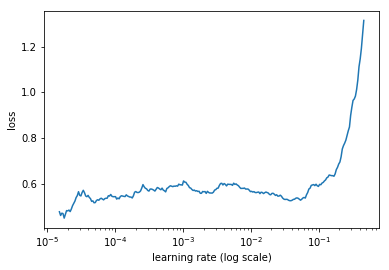

In [73]:
learn.sched.plot()

In [ ]:
#### conlusion

上面看loss并没有改进的余地了?

In [74]:
suitable_lr = 0.008

#### unfreeze and set muti-learning rate for other layer

In [76]:
learn.load('dogbreeds_224_1st')
learn.unfreeze()
lr=np.array([suitable_lr/100,suitable_lr/10,suitable_lr]);
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.76473    0.555561   0.829256  



[array([ 0.55556]), 0.82925635914513274]

In [ ]:
learn.save('dogbreeds_224_2nd_more_bad')
#### Decide not using this way

#### Train huge size image data set then!

In [77]:
learn.load('dogbreeds_224_1st')
sz = 299
learn.set_data(get_data(sz,bs))
learn.fit(suitable_lr,2,cycle_len=1)
# overfit?
#learn.fit(1e-2,3 cycle_len=1, cycle_mult=2)

A Jupyter Widget

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.527948   0.45088    0.861546  
    1      0.498697   0.436912   0.867906                    



[array([ 0.43691]), 0.86790606793592118]

#### TTA operation for validation set

TTA is kind of better predictiton. 
Prediction for valid dataset aparted from train set (20% of it)

In [82]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.87475538160469668

In [85]:
log_preds.shape

(5, 2044, 120)

In [86]:
learn.save('dogbreeds_224_2nd_good')

### Submit results

#### Predict on test set

In [154]:
fn = data.test_ds.fnames[:]
ids =[f.split(r'/')[1].split('.')[0] for f in fn];

In [87]:
learn.load('dogbreeds_224_2nd_good')

In [88]:
log_preds = learn.predict(is_test=True)

In [89]:
log_preds.shape

(10357, 120)

In [91]:
probs = np.exp(log_preds)
probs
probs.shape

(10357, 120)

In [93]:
#### gen submission file
sub_df = pd.read_csv(f'{PATH}sample_submission.csv')
sub_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [1]:
sub_df.shape

NameError: name 'sub_df' is not defined

SyntaxError: invalid syntax (<ipython-input-172-66b6bd8cdf6b>, line 1)

In [185]:
probs_1 = np.zeros(probs.shape);

for i in range(len(ids)):
    idx = np.where(np.array(ids) == sub_df.loc[i,'id'])
    idx = idx[0][0]
    probs_1[i] = probs[i]
    i = i+1

probs_1.shape



(10357, 120)

In [187]:
column_lists = sub_df.columns.tolist()
len(column_lists)

121

In [188]:
result_df = pd.DataFrame(data=probs_1)
result_df.shape

(10357, 120)

#### must re order to submit correctly

In [189]:

#RFC
results = pd.concat([sub_df['id'],result_df],axis=1);
results.columns = column_lists
results.shape
results.head()


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,8.591078e-08,1.460376e-05,2.480628e-08,3.800523e-07,2.741371e-09,5.520722e-09,9.067757e-08,1.226562e-07,8.611465e-09,...,5.955530e-05,2.900136e-09,4.025904e-08,3.949405e-09,1.333963e-08,1.461740e-07,8.134392e-09,2.614360e-08,1.280020e-07,1.993583e-08
1,00102ee9d8eb90812350685311fe5890,1.005466e-07,1.073510e-06,2.161224e-06,1.700407e-05,6.368897e-09,4.344273e-08,1.208660e-07,5.412582e-08,1.289059e-07,...,2.287189e-08,6.742130e-09,2.958223e-06,2.403591e-07,6.264216e-07,2.409136e-07,7.176047e-08,5.080661e-06,1.469607e-06,8.563315e-08
2,0012a730dfa437f5f3613fb75efcd4ce,1.236955e-07,2.055347e-07,1.917313e-07,4.587596e-06,2.212177e-07,1.408224e-05,7.585012e-08,2.656496e-07,1.299763e-04,...,1.644405e-07,2.386247e-07,1.815694e-04,1.651571e-04,5.468688e-05,2.214211e-09,1.323458e-08,9.699973e-08,1.250239e-07,3.859143e-07
3,001510bc8570bbeee98c8d80c8a95ec1,1.638046e-03,1.223492e-05,3.019909e-07,2.291612e-07,3.591502e-07,1.822307e-06,4.032031e-05,1.009087e-06,3.071570e-07,...,1.011180e-03,2.831102e-05,1.707223e-06,1.644417e-06,1.829662e-06,4.483909e-07,1.214011e-05,3.575389e-07,9.899763e-06,9.308383e-04
4,001a5f3114548acdefa3d4da05474c2e,4.089851e-07,1.090535e-06,3.197246e-07,2.185359e-08,1.844631e-07,1.404150e-07,8.799029e-06,2.737961e-08,9.288005e-07,...,1.498471e-04,4.712798e-07,2.098131e-07,2.484322e-08,3.796286e-06,6.677979e-07,3.585484e-04,2.010592e-07,6.476073e-06,6.787245e-05


In [190]:
results.to_csv("fastai_resnet34.csv",index = False);

In [191]:
#### submit
!kaggle competitions submit -c dog-breed-identification -f  "fastai_resnet34.csv" -m "1st resnet34-based result"

Successfully submitted to Dog Breed Identification